<h2>Minibatch SGD Numpy implementation </h2>
<h3>Problem Statement: Implement minibatch SGD using Numpy, experiment with different batch size(1, 10, 100, 1000) and comparison with PyTorch implemntation</h3>
<h3>1. Downloading the Dataset</h3>
<br> 
1.1 Downloading the gz files for training and testing dataset

In [2]:
import urllib.request
#Training data
urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "train-images.gz")
urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz", "train-labels.gz")

#Testing data
urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "test-images.gz")
urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz", "test-labels.gz")

('test-labels.gz', <http.client.HTTPMessage at 0x7fb1544b2520>)

1.2 Reading and normalizing the input data and creating one hot vectors from output data

In [2]:
import gzip
import numpy as np
def preprocess_data(data_file):
    with gzip.open(data_file,'r') as train_images:

# reading the meta information present in first 16 bytes
        train_images.read(4)
        num_of_examples = int.from_bytes(train_images.read(4), byteorder='big')
        num_of_rows = int.from_bytes(train_images.read(4), byteorder='big')
        num_of_cols = int.from_bytes(train_images.read(4), byteorder='big')

# reading images into numpy array
        data = np.frombuffer(
            train_images.read(num_of_examples * num_of_rows * num_of_cols),
            dtype=np.uint8)

# Normalizing each input image with zero mean and range -1 to 1.
    data = data.reshape(num_of_examples, num_of_rows * num_of_cols)
    data = data/np.var(data, axis=1)
    data = data - np.mean(data, axis=1).reshape(-1,1)

# adding the column of ones for bias parameter.
    data = np.append(data, np.ones((num_of_examples, 1)), axis=1)
    return data
data_train = preprocess_data('train-images.gz') 
data_test = preprocess_data('test-images.gz')

def preprocess_labels(labels_file):
    with gzip.open(labels_file,'r') as train_labels:
# reading the meta information present in first 8 bytes
        train_labels.read(4)
        num_of_examples = int.from_bytes(train_labels.read(4), byteorder='big')
# reading labels into numpy array
        labels = np.frombuffer(
            train_labels.read(num_of_examples),
            dtype=np.uint8)
# converting to one-hot encoding
    one_hot_labels = np.zeros((labels.shape[0], 10))
    one_hot_labels[np.arange(num_of_examples), labels] = 1
    return one_hot_labels
oh_labels_train = preprocess_labels('train-labels.gz')
oh_labels_test = preprocess_labels('test-labels.gz')

<h4>2. Minibatch SGD implementation</h4>

In [3]:
def gradient_descent(B, ITR, eta, train_d, train_l, test_d, test_l):
# Initializing the weights to zero
    W = np.zeros((train_l.shape[1], train_d.shape[1]))
    loss = []
    acc = []
    for i in range(ITR):
# Randomly choosing the datapoints from whole dataset with replacement.
        data_indexes = np.random.choice(np.arange(train_d.shape[0]), size=B, replace=True)
        x = train_d[data_indexes]
        y = train_l[data_indexes]
# Calculation of loss and accuracy at each 100th iteration. 
        if i%(ITR/100) == 0:
            loss.append(1/2*float(np.mean((train_l-np.matmul(train_d, W.T))**2))),
            acc.append(float(accuracy(np.matmul(test_d, W.T), test_l)))
# Calculating gradient and updating the parameters with it. 
        G = - np.matmul((y-np.matmul(x, W.T)).T, x) / B
        W = W - eta*G
    return loss, acc

<h4> 3. Analyzing the SGD for minibatch sizes 1, 10, 100 and 1000.</h4>
</br>
3.1 Calculation of Accuracy.

In [4]:
def accuracy(prediction, target):
    max_idxs = np.argmax(prediction, axis=1)
    result = target[np.arange(max_idxs.shape[0]), max_idxs] == 1
    result = result.astype(np.int8)
    return int(np.sum(result))/ result.shape[0]

3.2 Execution of SGD for selected best configurations and collecting the performace stats follwed the summary of execution.

In [5]:
# Best found configurations in format (Batch_Size, Iterations, Learning_Rate) 
best_configs = [
    (1, 100000, 0.0001),
    (10, 10000, 0.001),
    (100, 1000, 0.01),
    (1000, 1000, 0.01)]

# Execution of SGD with selected configurations of different batch sizes. 
import time
all_loss = []
for B, ITR, eta in best_configs:
    t1 = time.time()
    loss, acc = gradient_descent(B, ITR, eta,
                                 data_train, oh_labels_train,
                                 data_test, oh_labels_test)
    all_loss.append((loss, acc))

    print('Batch Size: ', B)
    print('Iterations: ', ITR)
    print('Learning Rate:', eta)
    print("Final Training Loss", loss[-1])
    print("Final Accuracy: ", acc[-1])
    print("Time: ", time.time()-t1)
    print()
  

Batch Size:  1
Iterations:  100000
Learning Rate: 0.0001
Final Training Loss 0.02059855313370517
Final Accuracy:  0.8602
Time:  25.484893560409546

Batch Size:  10
Iterations:  10000
Learning Rate: 0.001
Final Training Loss 0.02061099551431173
Final Accuracy:  0.8572
Time:  13.901893377304077

Batch Size:  100
Iterations:  1000
Learning Rate: 0.01
Final Training Loss 0.020618932570499727
Final Accuracy:  0.8581
Time:  11.896231889724731

Batch Size:  1000
Iterations:  1000
Learning Rate: 0.01
Final Training Loss 0.020543277170555062
Final Accuracy:  0.859
Time:  13.425697803497314



3.3 Plotting Average loss, Accuracy vs Iterations

In [41]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(axs, i, title):
    itr = best_configs[i][1]
    x_axis = range(0, itr, int(itr/100))
    axs[0].plot(
        x_axis,
        all_loss[i][0])
    axs[0].set_xlabel('Iteraions')
    axs[0].set_ylabel('Avg. Training Loss')
    axs[0].set_title(title)
    axs[1].plot(
        x_axis,
        all_loss[i][1])
    axs[1].set_xlabel('Iteraions')
    axs[1].set_ylabel('Test Accuracy')
    axs[1].set_title(title)

3.3.1 Batch size = 1

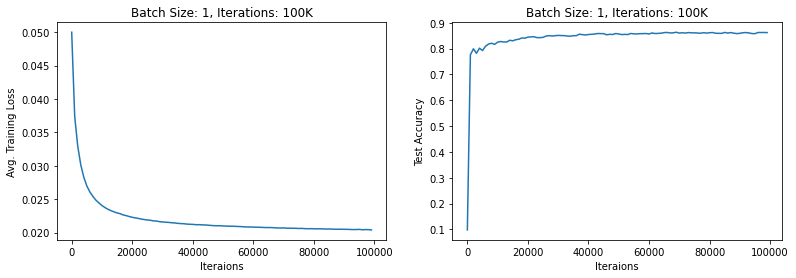

In [42]:
figure, axs = plt.subplots(1, 2, figsize=[13,4])
plot_loss_accuracy(axs, 0, 'Batch Size: 1, Iterations: 100K')

3.3.2 Batch size = 10

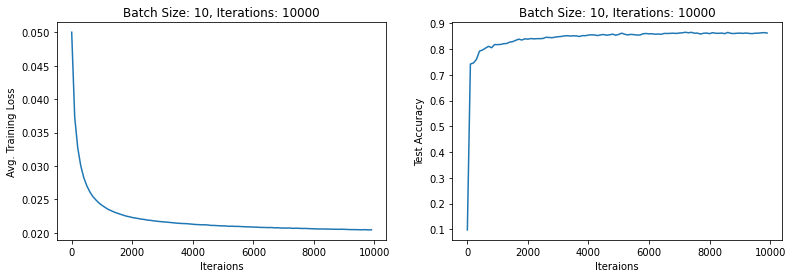

In [43]:
figure, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=[13,4])
plot_loss_accuracy(axs, 1, 'Batch Size: 10, Iterations: 10000')

3.3.3 Batch size = 100

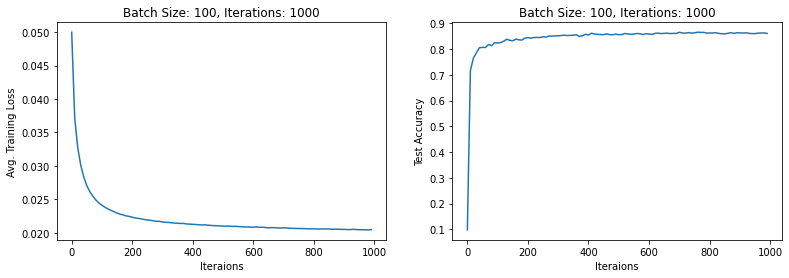

In [44]:
figure, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=[13,4])
plot_loss_accuracy(axs, 2, 'Batch Size: 100, Iterations: 1000')

3.3.4 Batch size = 10000

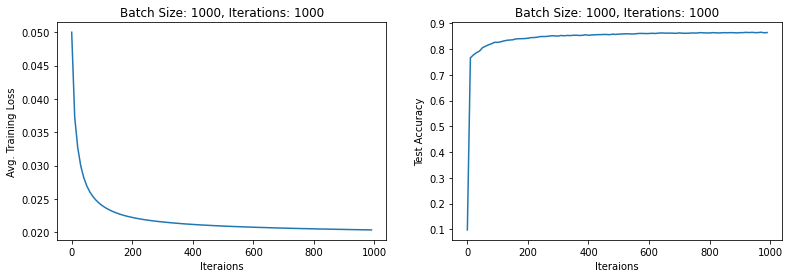

In [45]:
figure, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=[13,4])
plot_loss_accuracy(axs, 3, 'Batch Size: 1000, Iterations: 1000')

<h4> 4. Analyzing the SGD for different dataset sizes followed by the summary</h4> 

In [46]:
for data_size in [100, 500, 1000, 10000]:
    ITR = 1000
    eta = 0.01
    B = 100
    data_indexes = np.random.choice(np.arange(data_train.shape[0]), size=data_size, replace=False)
    data = data_train[data_indexes]
    labels = oh_labels_train[data_indexes]
    loss, acc = gradient_descent(B, ITR, eta,
                                data, labels,
                                data_test, oh_labels_test)
    print('Data Size: ', data_size)
    print('Iterations: ', ITR)
    print('Learning Rate:', eta)
    print("Final Training Loss", loss[-1])
    print("Final Accuracy: ", acc[-1])
    print()

Data Size:  100
Iterations:  1000
Learning Rate: 0.01
Final Training Loss 0.0020655780187256423
Final Accuracy:  0.6758

Data Size:  500
Iterations:  1000
Learning Rate: 0.01
Final Training Loss 0.014655766896600744
Final Accuracy:  0.8296

Data Size:  1000
Iterations:  1000
Learning Rate: 0.01
Final Training Loss 0.01774644191701822
Final Accuracy:  0.8367

Data Size:  10000
Iterations:  1000
Learning Rate: 0.01
Final Training Loss 0.020196550946079115
Final Accuracy:  0.8585



<h4> 5. Implementation of SGD with PyTorch and comparison with Numpy implementation.</h4>

In [73]:
import torch
linear_mnist_model = torch.nn.Linear(785, 10)
linear_mnist_model.weight.data.fill_(0)
linear_mnist_model.bias.data.fill_(0)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(linear_mnist_model.parameters(), lr=0.01)
td_train = torch.tensor(data_train)
tl_train = torch.tensor(oh_labels_train)
td_test = torch.tensor(data_test)
tl_test = torch.tensor(oh_labels_test)

dataset_train = torch.utils.data.TensorDataset(td_train, tl_train)
dataset_test = torch.utils.data.TensorDataset(td_test, tl_test)
sampler = torch.utils.data.RandomSampler(dataset_train, replacement=True, num_samples=100)
batch_sampler = torch.utils.data.BatchSampler(sampler=sampler, batch_size=100, drop_last=False)
dataloader = torch.utils.data.DataLoader(dataset_train, batch_sampler=batch_sampler)
torch_loss = []
torch_acc = []
ITR = 1000
for i in range(ITR):
    for data in dataloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = linear_mnist_model(inputs.float())
        loss = criterion(outputs, labels.float())
        if i%(ITR/100) == 0:
            torch_loss.append(float(loss)/2),
            torch_acc.append(
                accuracy(linear_mnist_model(td_test.float()).detach().numpy(),
                oh_labels_test))
        loss.backward()
        optimizer.step()

5.1 Comparison of PyTorch implementation with Numpy.

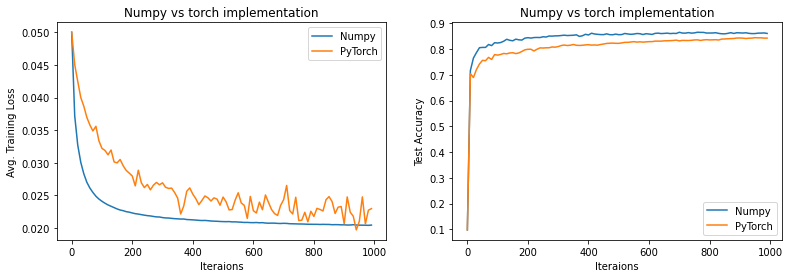

In [72]:
figure, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=[13,4])
title = 'Numpy vs torch implementation'
itr = best_configs[2][1]
x_axis = range(0, itr, int(itr/100))
axs[0].plot(
    x_axis,
    all_loss[2][0],
    label = 'Numpy'
)
axs[0].plot(
    x_axis,
    torch_loss,
    label = 'PyTorch'
)
axs[0].set_xlabel('Iteraions')
axs[0].set_ylabel('Avg. Training Loss')
axs[0].set_title(title)
axs[1].plot(
    x_axis,
    all_loss[2][1],
    label = 'Numpy'
)
axs[1].plot(
    x_axis,
    torch_acc,
    label = 'PyTorch'
)
axs[1].set_xlabel('Iteraions')
axs[1].set_ylabel('Test Accuracy')
axs[1].set_title(title)
axs[0].legend()
axs[1].legend()